Find high impact bands for each disease type

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pickle
import numpy as np
import pandas as pd
from pymongo import MongoClient

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Filter genes by high impact bands

Load data

In [3]:
matfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_weight.pkl'
labelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_label.pkl'
bandfile = '/Users/bogao/DataFiles/new landscape/data/bands.pkl'

with open(matfile, 'rb') as fmat, open(labelfile, 'rb') as flab, open(bandfile, 'rb') as fbd:
    data = pickle.load(fmat)
    labels = pickle.load(flab)
    bands = pickle.load(fbd)
    
genefile =  '/Users/bogao/DataFiles/Data/genome/genes.tsv'
genes = pd.read_csv(genefile, sep='\t', names=['gene_id', 'name', 'chr','start','end', 'symbol'], header=0)

Sum the signals of each disease, than choose the high impact bands

Brain
Ovary
Breast
Kidney
Prostate
Skin
Colon
Liver
Lung
Stomach


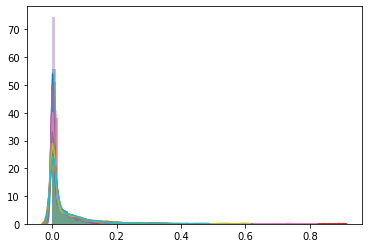

In [4]:
disease_names = ['Brain', 'Ovary', 'Breast', 'Kidney', 'Prostate', 'Skin', 'Colon', 'Liver', 'Lung', 'Stomach']
high_impact_bands = [False] * 1622
postive_data = np.maximum(data, 0)
sig_thresh = 0.2
for dname in disease_names:
    disease_data = postive_data[labels == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    print(dname)
    sns.distplot(sigsum)
    high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

high impact bands in dup and del

In [5]:
high_amp_bands = high_impact_bands[:811]

high_del_bands = high_impact_bands[811:]

print(sum(high_amp_bands))
print(sum(high_del_bands))

108
51


A new column for filtering

In [6]:
bands['band'] = bands['chr'].astype(str) + bands['name']

Band names for gene filtering

In [7]:
high_amp_bands_filter = bands[high_amp_bands]['band'].values
high_del_bands_filter = bands[high_del_bands]['band'].values

Prepare gene data

In [8]:
genes['band'] = genes['chr'].astype(str) + genes['name']

genes = genes.sort_values(['chr', 'start'])

High impact genes

In [9]:
high_amp_genes = genes[genes.band.isin(high_amp_bands_filter)]
high_del_genes = genes[genes.band.isin(high_del_bands_filter)]

print(len(high_amp_genes))
print(len(high_del_genes))

2294
735


Save to disk 

In [107]:
high_amp_genes.to_csv('/Users/bogao/DataFiles/Data/genome/high_amp_genes.tsv', sep='\t', index=0)
high_del_genes.to_csv('/Users/bogao/DataFiles/Data/genome/high_del_genes.tsv', sep='\t', index=0)

## Generate feature matrix of filtered genes

Load data

In [10]:
db = MongoClient()['Rebased']['mecaned']
samples = []
for sam in db.find({'cytobands':{ '$exists': True}},{'sample_id':1, 'normalized':1}):
    samples.append(sam)

In [11]:
len(samples)

42820

In [13]:
num_amp_genes = 2294
num_del_genes = 735

In [14]:
high_amp_genes = high_amp_genes.assign(total = 0)
high_amp_genes = high_amp_genes.assign(length = 0)
high_del_genes = high_del_genes.assign(total = 0)
high_del_genes = high_del_genes.assign(length = 0)

high_amp_genes = high_amp_genes.reset_index(drop=True)
high_del_genes = high_del_genes.reset_index(drop=True)

In [35]:
gene_mat = []
c = 0
for sam in samples:
    
    amp_genes = high_amp_genes.to_dict('records')
    del_genes = high_del_genes.to_dict('records')
    
    for seg in sam['normalized']:
        if seg['probes'] >4:
                    
            if seg['value'] >2:
                val = 2
            else:
                val = seg['value']


            # count all amp genes
            for g in amp_genes:    
                if (str(g['chr']) == seg['chro']) and (g['start'] < seg['end']) and (g['end'] >= seg['start']):
                    size = min(g['end'],seg['end']) - max(g['start'],seg['start'])

                    # dup
                    if seg['value'] > 0:
                        # update total value
                        g['total'] += size*seg['value']
                        # update total_length
                        g['length'] += size
                     
            # count all del genes
            for g in del_genes:
                if (str(g['chr']) == seg['chro']) and (g['start'] < seg['end']) and (g['end'] >= seg['start']):
                    size = min(g['end'],seg['end']) - max(g['start'],seg['start'])
                    # del
                    if seg['value'] < 0:
                        # update total value
                        g['total'] += size*seg['value']
                        # update total_length
                        g['length'] += size
                     
    
    gene_ave = []
    for g in amp_genes:
        if g['length'] >0:
            gene_ave.append(g['total']/g['length'])
        else:
            gene_ave.append(0)
    for g in del_genes:
        if g['length'] >0:
            gene_ave.append(g['total']/g['length'])
        else:
            gene_ave.append(0)
    
    gene_mat.append(gene_ave)
    

    print(c, end='\r')
    c +=1

In [36]:
outputfile = '/Users/bogao/DataFiles/new landscape/data/selected_gene_mat.pkl'
with open(outputfile, 'wb') as fo:
    pickle.dump(gene_mat, fo)

In [193]:
sum(gene_mat[0])

-450.6158243965679

In [37]:
len(gene_mat)

42820

In [38]:
data = np.array(gene_mat)

In [39]:
data.shape

(42820, 3029)

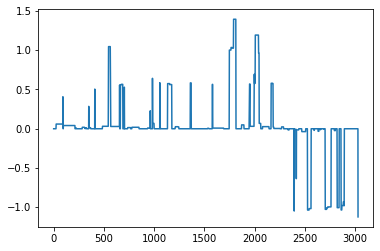

In [26]:
sns.lineplot(range(len(gene_mat[0])),gene_mat[1])

In [23]:
data.shape

(42820, 1622)

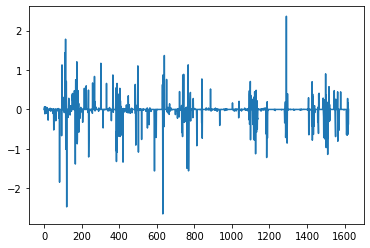

In [25]:
sns.lineplot(range(1622), data[1])

In [3]:
weightfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_weight.pkl'
with open(weightfile, 'rb') as fwt:
    weights = pickle.load(fwt)

In [4]:
weights.shape

(42820, 1622)

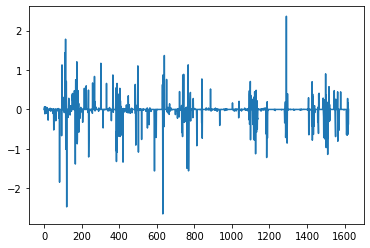

In [6]:
sns.lineplot(range(1622), weights[1])

In [30]:
w = weights[1]
w = w[w>0.2]

In [31]:
w.shape

(91,)

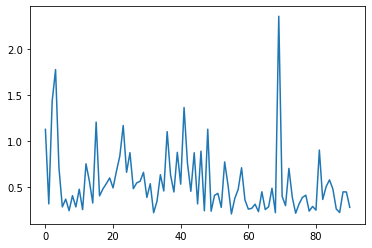

In [32]:
sns.lineplot(range(91), w)

In [7]:
w = weights[1]
w = w[w>=0]
w.shape

(1077,)

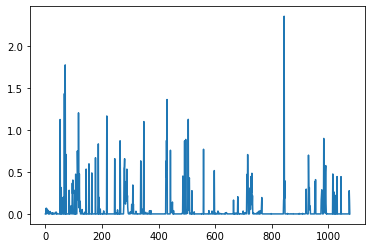

In [8]:
sns.lineplot(range(1077), w)